In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt


In [3]:
# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
df = individual_household_electric_power_consumption.data.features

# Convert 'Date' and 'Time' columns to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Convert 'Global_active_power' to numeric, coerce errors to NaN
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop rows with NaN values in 'Global_active_power'
df = df.dropna(subset=['Global_active_power'])

# Aggregate data to daily level by summing 'Global_active_power'
daily_data = df.groupby('Date').agg({'Global_active_power': 'sum'}).reset_index()

# Rename columns to fit Prophet's requirements
daily_data.columns = ['ds', 'y']

# Determine the length of the dataset
total_days = daily_data.shape[0]

# Split the data
train_size = total_days - 300
train_data = daily_data.iloc[:train_size]
test_data = daily_data.iloc[train_size:]

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(train_data)

# Make future dataframe for the test period
future_dates = model.make_future_dataframe(periods=300)

# Forecast
forecast = model.predict(future_dates)

# Extract the relevant part of the forecast
forecast_test = forecast[['ds', 'yhat']].tail(300)

# Merge forecast with the actual test data
test_data = test_data.merge(forecast_test, on='ds')

# Calculate evaluation metrics (e.g., MAE, RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data['y'], test_data['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], test_data['yhat']))
print('')
print('##############################################################')
print('')
display("MAE univariate:", mae)
display("RMSE univariate:", rmse)

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdxuj3sxi/de6duvvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdxuj3sxi/gi6wfty4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34636', 'data', 'file=/tmp/tmpdxuj3sxi/de6duvvt.json', 'init=/tmp/tmpdxuj3sxi/gi6wfty4.json', 'output', 'file=/tmp/tmpdxuj3sxi/prophet_modelq2decc8e/prophet_model-20240611081703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



##############################################################



'MAE univariate:'

293.1105462087479

'RMSE univariate:'

401.06376536987733

In [4]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test_data['y'], test_data['yhat']) * 100

print('MAPE univariate:', round(mape, 2), '%')


MAPE univariate: 33.45 %


Day of the weekly seasonality with the lowest value: 4


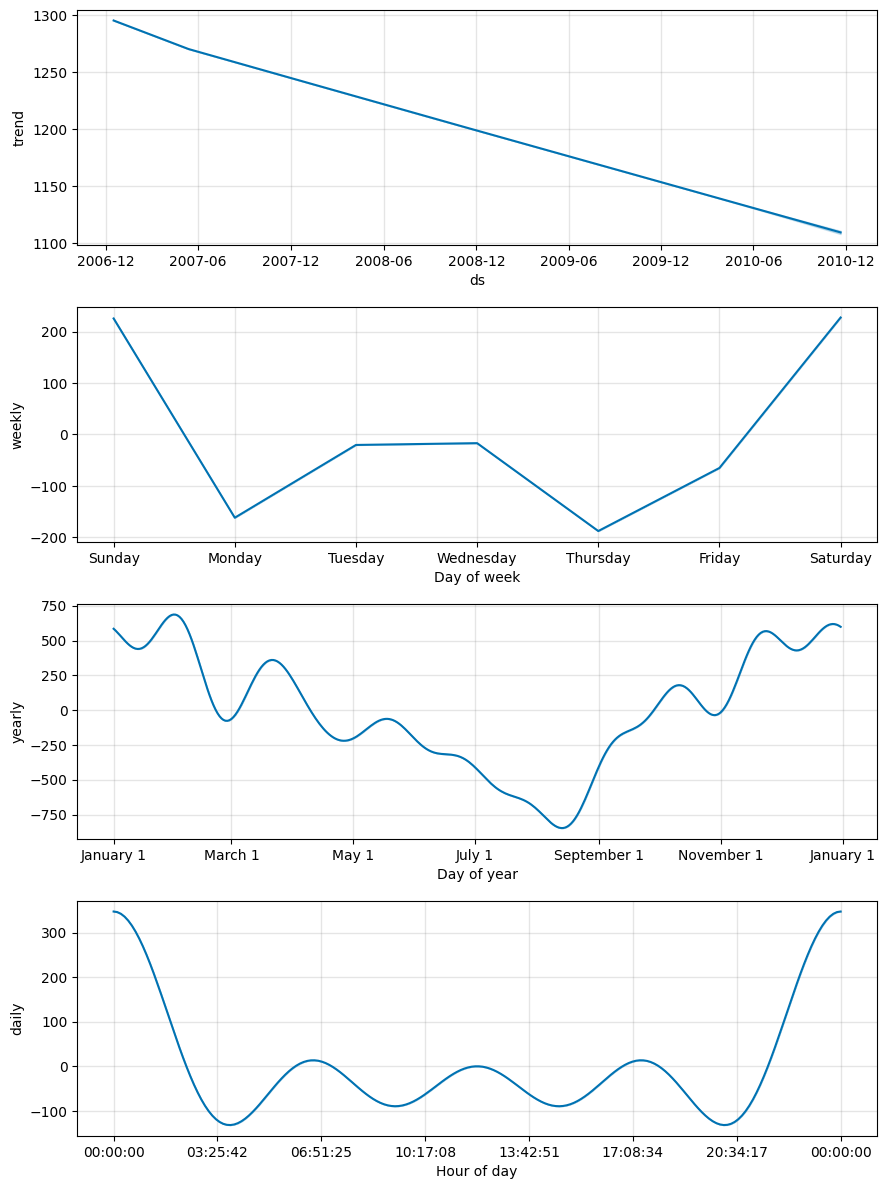

In [5]:
fig = model.plot_components(forecast)

# Access the axes for the weekly seasonality plot
axes = fig.get_axes()[1]

# Find the day with the lowest value
min_value = np.min(axes.lines[0].get_ydata())
min_day_index = np.argmin(axes.lines[0].get_ydata())

# Get the day of the week for the minimum value
min_day = axes.get_xticks()[min_day_index]

print("Day of the weekly seasonality with the lowest value:", min_day)


In [6]:
# copy dataframe
df_1 = df.copy()

# Convert 'Date' column to datetime
df_1['Date'] = pd.to_datetime(df_1['Date'], format='%d/%m/%Y')

# Convert necessary columns to numeric, coerce errors to NaN
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']
for col in cols_to_convert:
    df_1[col] = pd.to_numeric(df_1[col], errors='coerce')

# Drop rows with NaN values in any of the relevant columns
df_1 = df_1.dropna(subset=cols_to_convert)

# Aggregate data to daily level by summing the relevant columns
daily_data = df_1.groupby('Date').agg({
    'Global_active_power': 'sum',
    'Global_reactive_power': 'sum',
    'Voltage': 'mean',
    'Global_intensity': 'sum',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum'
}).reset_index()

# Rename columns to fit Prophet's requirements
daily_data.columns = ['ds', 'y', 'add1', 'add2', 'add3', 'add4', 'add5', 'add6']

# Determine the length of the dataset
total_days = daily_data.shape[0]

# Split the data
train_size = total_days - 300
train_data = daily_data.iloc[:train_size]
test_data = daily_data.iloc[train_size:]

# Initialize the Prophet model
model = Prophet(daily_seasonality=True)

# Add regressors
regressors = ['add1', 'add2', 'add3', 'add4', 'add5', 'add6']
for regressor in regressors:
    model.add_regressor(regressor)

# Fit the model
model.fit(train_data)

# Make future dataframe for the test period
future_dates = model.make_future_dataframe(periods=300)

# Add the regressors to the future dataframe
# We need to fill NaN values in the future_dates DataFrame
future_dates = future_dates.merge(daily_data[['ds'] + regressors], on='ds', how='left')

# Fill NaN values with the latest available data
future_dates.fillna(method='ffill', inplace=True)

# Forecast
forecast = model.predict(future_dates)

# Extract the relevant part of the forecast
forecast_test = forecast[['ds', 'yhat']].tail(300)

# Merge forecast with the actual test data
test_data = test_data.merge(forecast_test, on='ds')

# Calculate evaluation metrics (e.g., MAE, RMSE)
mae = mean_absolute_error(test_data['y'], test_data['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], test_data['yhat']))
print('')
print('##############################################################')
print('')
print(f'MAE multivariate: {mae}')
print(f'RMSE multivariate: {rmse}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdxuj3sxi/rvpdlt0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdxuj3sxi/6q5_4dbb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14932', 'data', 'file=/tmp/tmpdxuj3sxi/rvpdlt0z.json', 'init=/tmp/tmpdxuj3sxi/6q5_4dbb.json', 'output', 'file=/tmp/tmpdxuj3sxi/prophet_modelhousa0z5/prophet_model-20240611081721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



##############################################################

MAE multivariate: 10.975822921193675
RMSE multivariate: 13.952664165836133


Day of the daily seasonality with the lowest value: 13483.0


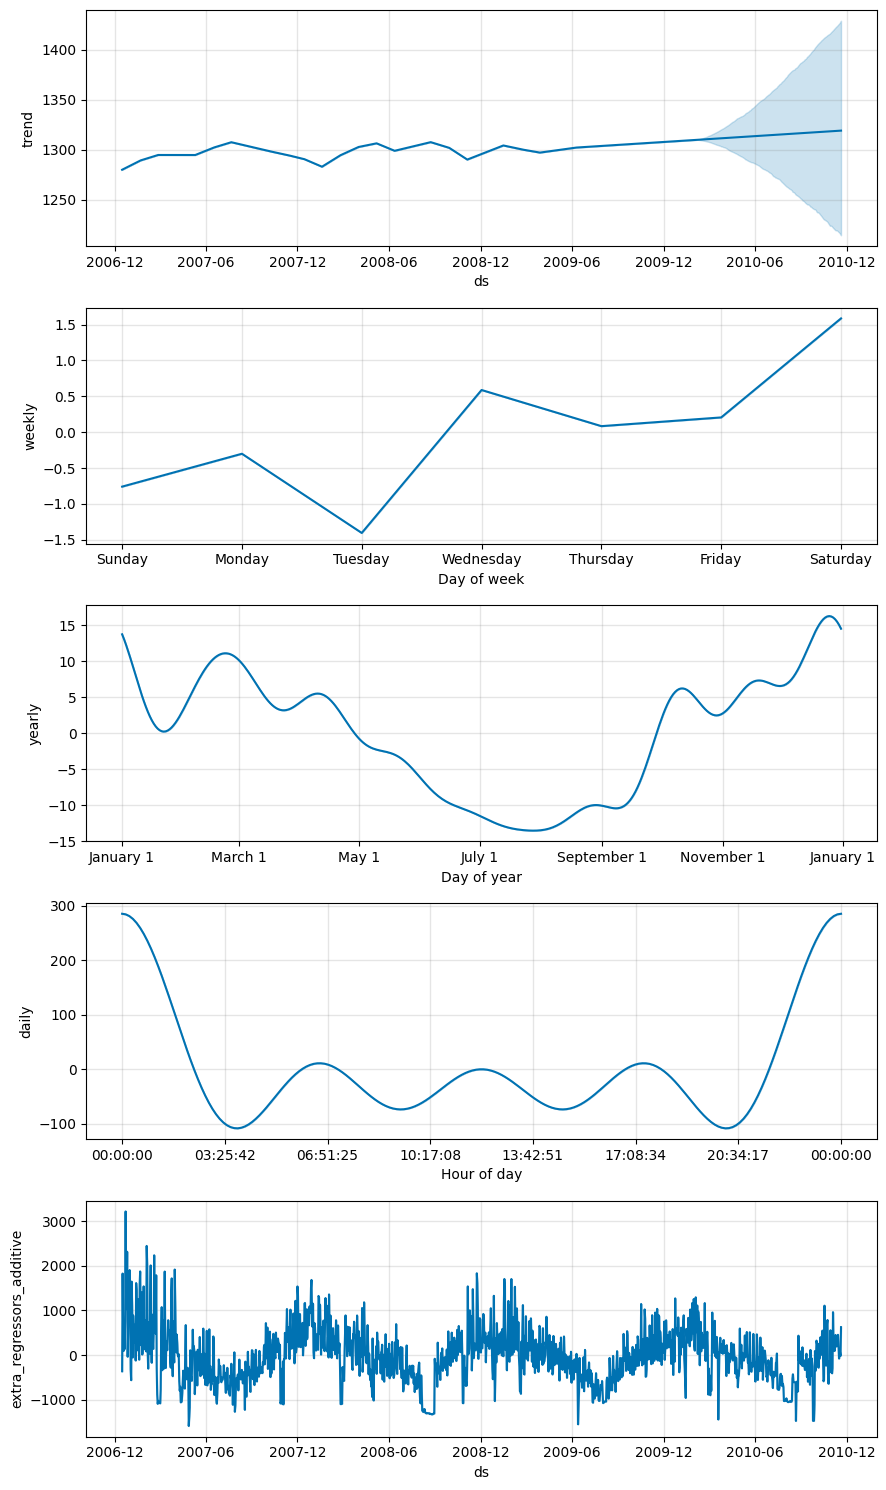

In [8]:
# Plot the components of the multivariate forecasted model
fig = model.plot_components(forecast)

# Access the axes for the daily seasonality plot
axes = fig.get_axes()[0]

# Find the day with the lowest value
min_value = np.min(axes.lines[0].get_ydata())
min_day_index = np.argmin(axes.lines[0].get_ydata())

# Get the day of the daily seasonality for the minimum value
min_day = axes.get_xticks()[min_day_index]

# Print the day with the lowest value
print(f"Day of the daily seasonality with the lowest value: {min_day}")


<ipython-input-40-798494587ad0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
<ipython-input-40-798494587ad0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
<ipython-input-40-798494587ad0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

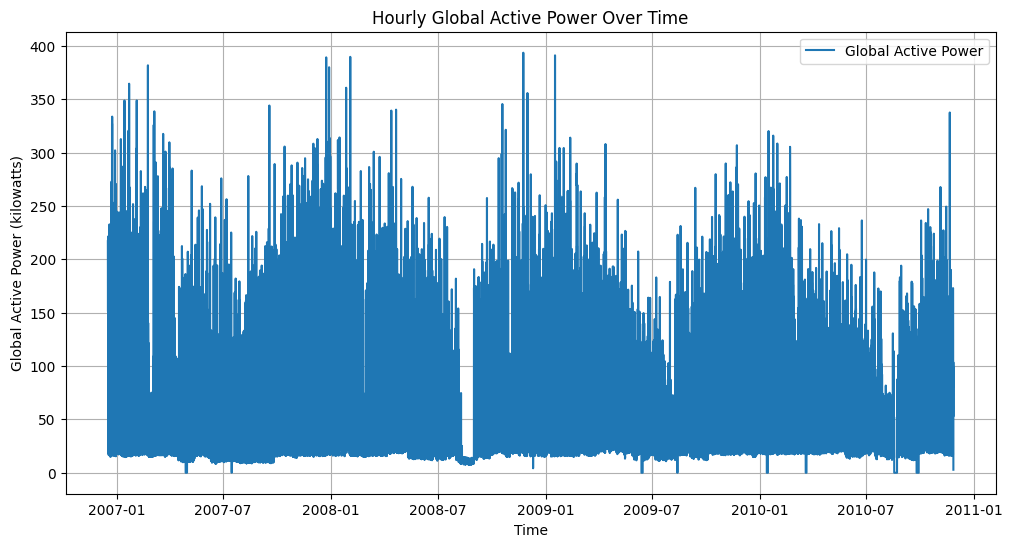

In [40]:
# Convert Date to string and concatenate with Time to create a DateTime column
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set DateTime as the index
df.set_index('DateTime', inplace=True)

# Convert the relevant columns to numeric, forcing errors to NaN to handle non-numeric values
cols_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Forward fill the NaN values
df.ffill(inplace=True)

# Resample to hourly frequency, summing the values
hourly_df = df.resample('H').sum()

# Plot the hourly Global_active_power over time
plt.figure(figsize=(12, 6))
plt.plot(hourly_df.index, hourly_df['Global_active_power'], label='Global Active Power')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Hourly Global Active Power Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Convert the relevant columns to numeric, forcing errors to NaN to handle non-numeric values
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')

# Forward fill the NaN values
df.ffill(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = df['Global_active_power'].corr(df['Voltage'])

<ipython-input-42-04cafc21d513>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
<ipython-input-42-04cafc21d513>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')


Pearson correlation coefficient: -0.400


<ipython-input-42-04cafc21d513>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)


In [43]:
# Print the correlation coefficient to 3 decimal places
print(f"Pearson correlation coefficient: {correlation:.3f}")

Pearson correlation coefficient: -0.400


In [48]:
# Convert the relevant columns to numeric, forcing errors to NaN to handle non-numeric values
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')

# Forward fill the NaN values
df.ffill(inplace=True)

# Calculate the Pearson correlation coefficient
correlation = df['Global_intensity'].corr(df['Voltage'])

<ipython-input-48-80717d07d899>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
<ipython-input-48-80717d07d899>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')


Pearson correlation coefficient: -0.41


<ipython-input-48-80717d07d899>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.ffill(inplace=True)


In [ ]:
# Print the correlation coefficient to 2 decimal places
print(f"Pearson correlation coefficient: {correlation:.2f}")